In [1]:
import os
os.chdir('CompositionalNets')
COMPOSITIONAL_NETS_PATH = './'
CODE_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'Code')
DATA_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'data')
MODELS_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'models')
import sys
sys.path.append(CODE_PATH)

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from config import categories, categories_train, dataset, data_path, device_ids, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from config import config as cfg
from model import Net
from helpers import getVmfKernels, getCompositionModel, update_clutter_model, myresize
from eval_occlusion_localization import visualize_response_map
import tqdm
from tqdm import tqdm_notebook
import torchvision.models as models
from torchvision import transforms
import cv2
import pdb
from PIL import Image
from glob import glob
import tarfile
import pandas as pd
import pdb
from sklearn.model_selection import train_test_split

from model import Net
from helpers import save_checkpoint,getCompositionModel,getVmfKernels, update_clutter_model
from config import device_ids, mix_model_path, categories, categories_train, dict_dir, dataset, data_path, layer, vc_num, model_save_dir, compnet_type,backbone_type, vMF_kappa,num_mixtures
from config import config as cfg
from torch.utils.data import DataLoader
from losses import ClusterLoss
from model import resnet_feature_extractor
import torchvision.models as models

import time
import os
import torch
import torch.nn as nn
import numpy as np
import random
import zipfile
import matplotlib.pyplot as plt

In [3]:
def getImg(archive, mode, categories, dataset, data_path, 
           cat_test=None, occ_level='ZERO', occ_type=None, bool_load_occ_mask = False):

    if mode == 'train':
        train_imgs = []
        train_labels = []
        train_masks = []
        for category in categories:
            if dataset == 'pascal3d+':
                if occ_level == 'ZERO':
                    filelist = 'pascal3d+_occ/' + category + '_imagenet_train' + '.txt'
                    img_dir = 'pascal3d+_occ/TRAINING_DATA/' + category + '_imagenet'
            elif dataset == 'coco':
                if occ_level == 'ZERO':
                    img_dir = 'coco_occ/{}_zero'.format(category)
                    filelist = 'coco_occ/{}_{}_train.txt'.format(category, occ_level)

            with archive.open(filelist, 'r') as fh:
                contents = fh.readlines()
            img_list = [cc.strip().decode('ascii') for cc in contents]
            label = categories.index(category)
            for img_path in img_list:
                if dataset=='coco':
                    if occ_level == 'ZERO':
                        img = img_dir + '/' + img_path + '.jpg'
                    else:
                        img = img_dir + '/' + img_path + '.JPEG'
                else:
                    img = img_dir + '/' + img_path + '.JPEG'
                occ_img1 = []
                occ_img2 = []
                train_imgs.append(img)
                train_labels.append(label)
                train_masks.append([occ_img1,occ_img2])
        
        return train_imgs, train_labels, train_masks

    else:
        test_imgs = []
        test_labels = []
        occ_imgs = []
        for category in cat_test:
            if dataset == 'pascal3d+':
                filelist = data_path + 'pascal3d+_occ/' + category + '_imagenet_occ.txt'
                img_dir = data_path + 'pascal3d+_occ/' + category + 'LEVEL' + occ_level
                if bool_load_occ_mask:
                    if  occ_type=='':
                        occ_mask_dir = 'pascal3d+_occ/' + category + 'LEVEL' + occ_level+'_mask_object'
                    else:
                        occ_mask_dir = 'pascal3d+_occ/' + category + 'LEVEL' + occ_level+'_mask'
                    occ_mask_dir_obj = 'pascal3d+_occ/0_old_masks/'+category+'_imagenet_occludee_mask/'
            elif dataset == 'coco':
                if occ_level == 'ZERO':
                    img_dir = 'coco_occ/{}_zero'.format(category)
                    filelist = 'coco_occ/{}_{}_test.txt'.format(category, occ_level)
                else:
                    img_dir = 'coco_occ/{}_occ'.format(category)
                    filelist = 'coco_occ/{}_{}.txt'.format(category, occ_level)

#             if os.path.exists(filelist):
            with archive.open(filelist, 'r') as fh:
                contents = fh.readlines()
            img_list = [cc.strip().decode('ascii') for cc in contents]
            label = categories.index(category)
            for img_path in img_list:
                if dataset != 'coco':
                    if occ_level=='ZERO':
                        img = img_dir + occ_type + '/' + img_path[:-2] + '.JPEG'
                        occ_img1 = []
                        occ_img2 = []
                    else:
                        img = img_dir + occ_type + '/' + img_path + '.JPEG'
                        if bool_load_occ_mask:
                            occ_img1 = occ_mask_dir + '/' + img_path + '.JPEG'
                            occ_img2 = occ_mask_dir_obj + '/' + img_path + '.png'
                        else:
                            occ_img1 = []
                            occ_img2 = []

                else:
                    img = img_dir + occ_type + '/' + img_path + '.jpg'
                    occ_img1 = []
                    occ_img2 = []

                test_imgs.append(img)
                test_labels.append(label)
                occ_imgs.append([occ_img1,occ_img2])
#             else:
#                 print('FILELIST NOT FOUND: {}'.format(filelist))
        return test_imgs, test_labels, occ_imgs


def train(model, train_data, val_data, epochs, batch_size, learning_rate, savedir, occ_types, alpha=3,beta=3, vc_flag=True, mix_flag=False):
    best_check = {
        'epoch': 0,
        'best': 0,
        'val_acc': 0
    }
    out_file_name = savedir + 'result.txt'
    total_train = len(train_data)
    train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
    val_loaders=[]

    for i in range(len(val_data)):
        val_loader = DataLoader(dataset=val_data[i], batch_size=1, shuffle=True)
        val_loaders.append(val_loader)

    # we observed that training the backbone does not make a very big difference but not training saves a lot of memory
    # if the backbone should be trained, then only with very small learning rate e.g. 1e-7
    for param in model.backbone.parameters():
        param.requires_grad = False

    if not vc_flag:
        model.conv1o1.weight.requires_grad = False
    else:
        model.conv1o1.weight.requires_grad = True

    if not mix_flag:
        model.mix_model.requires_grad = False
    else:
        model.mix_model.requires_grad = True

    classification_loss = nn.CrossEntropyLoss()
    cluster_loss = ClusterLoss()

    optimizer = torch.optim.Adagrad(params=filter(lambda param: param.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.98)

    print('Training')

    for epoch in range(epochs):
        out_file = open(out_file_name, 'a')
        train_loss = 0.0
        correct = 0
        start = time.time()
        model.train()
        model.backbone.eval()
        for index, data in enumerate(train_loader):
            if index % 500 == 0 and index != 0:
                end = time.time()
                print('Epoch{}: {}/{}, Acc: {}, Loss: {} Time:{}'.format(epoch + 1, index, total_train, correct.cpu().item() / index, train_loss.cpu().item() / index, (end-start)))
                start = time.time()

            input, _, label = data

            input = input.cuda(device_ids[0])
            label = label.cuda(device_ids[0])

            output, vgg_feat, like = model(input)

            out = output.argmax(1)
            correct += torch.sum(out == label)
            class_loss = classification_loss(output, label) / output.shape[0]

            loss = class_loss
            if alpha != 0:
                clust_loss = cluster_loss(vgg_feat, model.conv1o1.weight) / output.shape[0]
                loss += alpha * clust_loss

            if beta!=0:
                mix_loss = like[0,label[0]]
                loss += -beta *mix_loss

            #with torch.autograd.set_detect_anomaly(True):
            loss.backward()

            # pseudo batches
            if np.mod(index,batch_size)==0:# and index!=0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.detach() * input.shape[0]

        updated_clutter = update_clutter_model(model,device_ids, occ_types)
        model.clutter_model = updated_clutter
        scheduler.step()
        train_acc = correct.cpu().item() / total_train
        train_loss = train_loss.cpu().item() / total_train
        out_str = 'Epochs: [{}/{}], Train Acc:{}, Train Loss:{}'.format(epoch + 1, epochs, train_acc, train_loss)
        print(out_str)
        out_file.write(out_str)

        # Evaluate Validation images
        model.eval()
        with torch.no_grad():
            correct = 0
            val_accs=[]
            for i in range(len(val_loaders)):
                val_loader = val_loaders[i]
                correct_local=0
                total_local = 0
                val_loss = 0
                out_pred = torch.zeros(len(val_data[i].images))
                for index, data in enumerate(val_loader):
                    input,_, label = data
                    input = input.cuda(device_ids[0])
                    label = label.cuda(device_ids[0])
                    output,_,_ = model(input)
                    out = output.argmax(1)
                    out_pred[index] = out
                    correct_local += torch.sum(out == label)
                    total_local += label.shape[0]

                    class_loss = classification_loss(output, label) / output.shape[0]
                    loss = class_loss
                    val_loss += loss.detach() * input.shape[0]
                correct += correct_local
                val_acc = correct_local.cpu().item() / total_local
                val_loss = val_loss.cpu().item() / total_local
                val_accs.append(val_acc)
                out_str = 'Epochs: [{}/{}], Val-Set {}, Val Acc:{} Val Loss:{}\n'.format(epoch + 1, epochs,i , val_acc,val_loss)
                print(out_str)
                out_file.write(out_str)
            val_acc = np.mean(val_accs)
            out_file.write('Epochs: [{}/{}], Val Acc:{}\n'.format(epoch + 1, epochs, val_acc))
            if val_acc>best_check['val_acc']:
                print('BEST: {}'.format(val_acc))
                out_file.write('BEST: {}\n'.format(val_acc))
                best_check = {
                    'state_dict': model.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch
                }
                save_checkpoint(best_check, savedir + 'vc' + str(epoch + 1) + '.pth', True)

            print('\n')
        out_file.close()
    return best_check


def imgLoader(archive, img_path,mask_path,bool_resize_images=True,bool_square_images=False):
    
    archive_img_path = archive.open(img_path)
    input_image = Image.open(archive_img_path)
    if bool_resize_images:
        if bool_square_images:
            input_image.resize((224,224),Image.ANTIALIAS)
        else:
            sz=input_image.size
            min_size = np.min(sz)
            if min_size!=224:
                input_image = input_image.resize((np.asarray(sz) * (224 / min_size)).astype(int),Image.ANTIALIAS)
    preprocess =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    img = preprocess(input_image)

    if mask_path[0]:
        f = archive.open(mask_path[0])
        mask1 = np.array(Image.open(f))
        f.close()
        mask1 = myresize(mask1, 224, 'short')
        try:
            mask2 = cv2.imread(mask_path[1])[:, :, 0]
            mask2 = mask2[:mask1.shape[0], :mask1.shape[1]]
        except:
            mask = mask1
        try:
            mask = ((mask1 == 255) * (mask2 == 255)).astype(np.float)
        except:
            mask = mask1
    else:
        mask = np.ones((img.shape[0], img.shape[1])) * 255.0

    mask = torch.from_numpy(mask)
    return img,mask


class Imgset():
    def __init__(self, archive, imgs, masks, labels, loader,bool_square_images=False):
        self.archive = archive
        self.images = imgs
        self.masks 	= masks
        self.labels = labels
        self.loader = loader
        self.bool_square_images = bool_square_images

    def __getitem__(self, index):
        fn = self.images[index]
        label = self.labels[index]
        mask = self.masks[index]
        img,mask = self.loader(self.archive,fn,mask,bool_resize_images=True,bool_square_images=self.bool_square_images)
        return img, mask, label

    def __len__(self):
        return len(self.images)

def save_checkpoint(state, filename, is_best):
    if is_best:
        print("=> Saving new checkpoint")
        torch.save(state, filename)
    else:
        print("=> Validation Accuracy did not improve")

In [6]:
if device_ids: print("GPU Available")
else: print("CPU")
archive = zipfile.ZipFile(os.path.join(DATA_PATH, 'CompNet_data.zip'))

#---------------------
# Training Parameters
#---------------------
alpha = 3  # vc-loss
beta = 3 # mix loss
likely = 0.6 # occlusion likelihood
lr = 1e-2 # learning rate
batch_size = 1 # these are pseudo batches as the aspect ratio of images for CompNets is not square
# Training setup
vc_flag = True # train the vMF kernels
mix_flag = True # train mixture components
ncoord_it = 1 	#number of epochs to train

bool_mixture_model_bg = False #True: use a mixture of background models per pixel, False: use one bg model for whole image
bool_load_pretrained_model = False
bool_train_with_occluders = False
dataset="pascal3d+"

if bool_train_with_occluders:
    occ_levels_train = ['ZERO', 'ONE', 'FIVE', 'NINE']
else:
    occ_levels_train = ['ZERO']

out_dir = model_save_dir + 'train_{}_a{}_b{}_vc{}_mix{}_occlikely{}_vc{}_lr_{}_{}_pretrained{}_epochs_{}_occ{}_backbone{}/'.format(
    layer, alpha,beta, vc_flag, mix_flag, likely, vc_num, lr, dataset, bool_load_pretrained_model,ncoord_it,bool_train_with_occluders,backbone_type)

GPU Available


In [7]:
if backbone_type=='vgg':
    if layer=='pool4':
        extractor = models.vgg16(pretrained=True).features[0:24]
    else:
        extractor = models.vgg16(pretrained=True).features
elif backbone_type=='resnet50' or backbone_type=='resnext':
    extractor = resnet_feature_extractor(backbone_type, layer)

extractor.cuda(device_ids[0]).eval()
weights = getVmfKernels(dict_dir, device_ids)

if bool_load_pretrained_model:
    pretrained_file = 'PATH TO .PTH FILE HERE'
else:
    pretrained_file = ''

occ_likely = []
for i in range(len(categories_train)):
    # setting the same occlusion likelihood for all classes
    occ_likely.append(likely)

# load the CompNet initialized with ML and spectral clustering
occ_types = ['ZERO']
mix_models = getCompositionModel(device_ids,mix_model_path,layer,categories_train,compnet_type=compnet_type)
net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
          bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
          num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD,
         occ_types=occ_types)
if bool_load_pretrained_model:
    net.load_state_dict(torch.load(pretrained_file, map_location='cuda:{}'.format(device_ids[0]))['state_dict'])

net = net.cuda(device_ids[0])

train_imgs=[]
train_masks = []
train_labels = []
val_imgs = []
val_labels = []
val_masks=[]
zipfile_fp = os.path.join(DATA_PATH, 'CompNet_data.zip')
archive = zipfile.ZipFile(zipfile_fp)

# get training and validation images
for occ_level in occ_levels_train:
    if occ_level == 'ZERO':
        occ_types = ['']
        train_fac=0.9
    else:
        occ_types = ['_white', '_noise', '_texture', '']
        train_fac=0.1

    for occ_type in occ_types:
        imgs, labels, masks = getImg(archive, 'train', categories_train, dataset, data_path, 
                                     categories, occ_level, occ_type, bool_load_occ_mask=False)
        nimgs=len(imgs)
        for i in range(nimgs):
            if (random.randint(0, nimgs - 1) / nimgs) <= train_fac:
                train_imgs.append(imgs[i])
                train_labels.append(labels[i])
                train_masks.append(masks[i])
            elif not bool_train_with_occluders:
                val_imgs.append(imgs[i])
                val_labels.append(labels[i])
                val_masks.append(masks[i])

print('Total imgs for train ' + str(len(train_imgs)))
print('Total imgs for val ' + str(len(val_imgs)))
train_imgset = Imgset(archive, train_imgs,train_masks, train_labels, imgLoader,bool_square_images=False)

val_imgsets = []
if val_imgs:
    val_imgset = Imgset(archive, val_imgs,val_masks, val_labels, imgLoader,bool_square_images=False)
    val_imgsets.append(val_imgset)

# write parameter settings into output folder
load_flag = False
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
info = out_dir + 'config.txt'
config_file = open(info, 'a')
config_file.write(dataset)
out_str = 'layer{}_a{}_b{}_vc{}_mix{}_occlikely{}_vc{}_lr{}/'.format(layer,alpha,beta,vc_flag,mix_flag,likely,vc_num,lr)
config_file.write(out_str)
out_str = 'Train\nDir: {}, vMF_kappa: {}, alpha: {},beta: {}, likely:{}\n'.format(out_dir, vMF_kappa, alpha,beta,likely)
config_file.write(out_str)
print(out_str)
out_str = 'pretrain{}_file{}'.format(bool_load_pretrained_model,pretrained_file)
print(out_str)
config_file.write(out_str)
config_file.close()

Total imgs for train 9898
Total imgs for val 1146
Train
Dir: models/train_pool5_a3_b3_vcTrue_mixTrue_occlikely0.6_vc512_lr_0.01_pascal3d+_pretrainedFalse_epochs_1_occFalse_backbonevgg/, vMF_kappa: 30, alpha: 3,beta: 3, likely:0.6

pretrainFalse_file


In [8]:
train(model=net, train_data=train_imgset, val_data=val_imgsets, epochs=ncoord_it, batch_size=batch_size,
      learning_rate=lr, savedir=out_dir, alpha=alpha,beta=beta, vc_flag=vc_flag, mix_flag=mix_flag, occ_types=occ_types)
print('Done')

Training
Epoch1: 500/9898, Acc: 0.97, Loss: -39.04712109375 Time:32.35302233695984
Epoch1: 1000/9898, Acc: 0.972, Loss: -39.71989453125 Time:29.01749062538147


KeyboardInterrupt: 

In [12]:
torch.save(net.state_dict(), 'models/reproduce/50_epochs.pth')

In [10]:
net_test = Net(extractor, weights, vMF_kappa, occ_likely, 
               mix_models, bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
               num_mixtures=num_mixtures, 
               vc_thresholds=cfg.MODEL.VC_THRESHOLD)
net_test.load_state_dict(torch.load('models/reproduce/50_epochs.pth'))

# Test

In [13]:
from Code.test import test

In [14]:
occ_levels = ['ZERO', 'ONE', 'FIVE', 'NINE']

In [15]:
if compnet_type=='bernoulli':
    bool_mixture_model_bg = True

if bool_load_pretrained_model:
    if backbone_type=='vgg':
        if layer=='pool5':
            if dataset=='pascal3d+':
                vc_dir = model_save_dir+'vgg_pool5_p3d+/'
            elif dataset=='coco':
                vc_dir = model_save_dir+'vgg_pool5_coco/'

    vc_file = vc_dir + 'best.pth'
    outdir = vc_dir
else:
    vc_dir = model_save_dir+'compnet_{}_{}_{}_initialization/'.format(layer,compnet_type,likely,dataset)
    vc_path = ''
    outdir = vc_dir

if not os.path.exists(outdir):
    os.makedirs(outdir)
info = outdir + 'config.txt'

occ_likely = []
for i in range(len(categories_train)):
    occ_likely.append(likely)
    
net_test = Net(extractor, weights, vMF_kappa, occ_likely, 
               mix_models, bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
               num_mixtures=num_mixtures, 
               vc_thresholds=cfg.MODEL.VC_THRESHOLD,
              occ_types=occ_levels)
net_test.load_state_dict(torch.load('models/reproduce/1.pth'))
nets = [net_test]

  0%|          | 1/4341 [00:00<07:44,  9.34it/s]

Total imgs for test of occ_level ZERO and occ_type  4341
Testing


100%|██████████| 4341/4341 [01:27<00:00, 49.58it/s]


Class aeroplane: 0.995
Class bicycle: 0.907
Class bus: 0.990
Class car: 0.982
Class motorbike: 0.946
Class train: 0.916
Model Name: Occ_level:ZERO, Occ_type:, Acc:0.9705137065192352


  0%|          | 0/4341 [00:00<?, ?it/s]

Total imgs for test of occ_level ONE and occ_type  4341
Testing


100%|██████████| 4341/4341 [02:07<00:00, 34.02it/s]


Class aeroplane: 0.981
Class bicycle: 0.861
Class bus: 0.898
Class car: 0.960
Class motorbike: 0.892
Class train: 0.839
Model Name: Occ_level:ONE, Occ_type:, Acc:0.9320433079935498


  0%|          | 1/4341 [00:00<09:37,  7.52it/s]

Total imgs for test of occ_level FIVE and occ_type  4341
Testing


100%|██████████| 4341/4341 [02:07<00:00, 33.92it/s]


Class aeroplane: 0.975
Class bicycle: 0.800
Class bus: 0.773
Class car: 0.879
Class motorbike: 0.848
Class train: 0.797
Model Name: Occ_level:FIVE, Occ_type:, Acc:0.8682331260078323


  0%|          | 1/4341 [00:00<10:32,  6.87it/s]

Total imgs for test of occ_level NINE and occ_type  4341
Testing


100%|██████████| 4341/4341 [02:09<00:00, 33.62it/s]


Class aeroplane: 0.965
Class bicycle: 0.725
Class bus: 0.588
Class car: 0.704
Class motorbike: 0.805
Class train: 0.742
Model Name: Occ_level:NINE, Occ_type:, Acc:0.7505183137525916


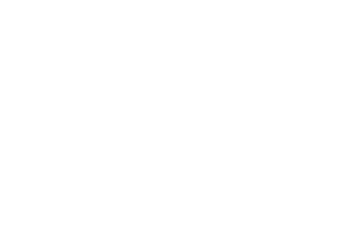

In [16]:
############################
# Test Loop
############################
for occ_level in occ_levels:

    if occ_level == 'ZERO':
        occ_types = ['']
    else:
        if dataset=='pascal3d+':
            occ_types = ['']#['_white','_noise', '_texture', '']
        elif dataset=='coco':
            occ_types = ['']

    for index, occ_type in enumerate(occ_types):
        # load images
        data_path = ''
        test_imgs, test_labels, masks = getImg(archive, 'test', categories_train, dataset, data_path, 
                                     categories, occ_level, occ_type, bool_load_occ_mask=True)
        print('Total imgs for test of occ_level {} and occ_type {} '.format(occ_level, occ_type) + str(len(test_imgs)))
        # get image loader
        test_imgset = Imgset(archive, test_imgs, masks, test_labels, imgLoader, bool_square_images=False)
        # compute test accuracy
        acc,scores = test(models=nets, test_data=test_imgset, batch_size=1)
        out_str = 'Model Name: Occ_level:{}, Occ_type:{}, Acc:{}'.format(occ_level, occ_type, acc)
        print(out_str)
        
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        last_idx = 5
        test_loader = DataLoader(test_imgset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for i, data in enumerate(test_loader):
                input_img, mask, label = data
                if device_ids:
                    input_img = input_img.cuda(device_ids[0])
        #         c_label = label.numpy()

        #         output, *_ = model(input_img)
        #         out = output.cpu().numpy().argmax(-1)[0]
        #         results.append(out)
        #         pred_class = categories_train[out]
        #         print('\nImage {} classified as {}'.format(img_name,pred_class))
                #localize occluder

                score, occ_maps, part_scores = net.get_occlusion(input_img, label)
                occ_map = occ_maps[0].detach().cpu().numpy()
                occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
                occ_img = visualize_response_map(occ_map, tit='',cbarmax=10, show=False)

                # concatenate original image and occluder map
                img_orig = np.array(Image.open(archive.open(test_imgs[i])))
        #         img_orig = np.array(input_img.squeeze().cpu().permute(1, 2, 0))
        #         img_orig = img_orig * std + mean
        #         img_orig = (255*(img_orig - np.min(img_orig))/np.ptp(img_orig).astype(int)).astype('uint8')
        #         faco = img_orig.shape[0] / occ_img.shape[0]
        #         occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
                occ_img_s = Image.fromarray(occ_img).resize((img_orig.shape[1], img_orig.shape[0]))
        #         occ_img_s = cv2.resize(occ_img, (img_orig.shape[1], img_orig.shape[0]))
        #         occ_img_s = np.array(transforms.ToTensor()(occ_img_s).permute(1, 2, 0)) * std + mean
        #         occ_img_s = occ_img_s.astype('float64')
        #         occ_img_s = (occ_img_s - np.min(occ_img_s))/np.ptp(occ_img_s)
                out_name = f'results/reproduce/without_occluder_2/{occ_level}_{i:04d}.png'
                canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        #         Image.fromarray(canvas).save(out_name)
        #         cv2.imwrite(out_name, canvas)
#                 plt.imshow(canvas)
                plt.axis('off')
                plt.imsave(out_name, canvas)

                if i == last_idx: break
        # print(f'Accuracy: {accuracy_score(test_labels, results)}')

In [ ]:
model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
last_idx = 5

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader)):
        input_img, mask, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
#         c_label = label.numpy()
        
#         output, *_ = model(input_img)
#         out = output.cpu().numpy().argmax(-1)[0]
#         results.append(out)
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
    
        score, occ_maps, part_scores = net.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=10, show=False)
        
        # concatenate original image and occluder map
        img_orig = np.array(Image.open(archive.open(test_images[i])))
#         img_orig = np.array(input_img.squeeze().cpu().permute(1, 2, 0))
#         img_orig = img_orig * std + mean
#         img_orig = (255*(img_orig - np.min(img_orig))/np.ptp(img_orig).astype(int)).astype('uint8')
#         faco = img_orig.shape[0] / occ_img.shape[0]
#         occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        occ_img_s = Image.fromarray(occ_img).resize((img_orig.shape[1], img_orig.shape[0]))
#         occ_img_s = cv2.resize(occ_img, (img_orig.shape[1], img_orig.shape[0]))
#         occ_img_s = np.array(transforms.ToTensor()(occ_img_s).permute(1, 2, 0)) * std + mean
#         occ_img_s = occ_img_s.astype('float64')
#         occ_img_s = (occ_img_s - np.min(occ_img_s))/np.ptp(occ_img_s)
        out_name = f'results/reproduce/without_occluder/{i:04d}.png'
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
#         Image.fromarray(canvas).save(out_name)
#         cv2.imwrite(out_name, canvas)
        plt.imshow(canvas)
        plt.axis('off')
        plt.imsave(out_name, canvas)
        
        if i == last_idx: break
# print(f'Accuracy: {accuracy_score(test_labels, results)}')